In [1]:
!pip install keras==3.10.0

In [2]:
import os

import keras
import pandas as pd
import numpy as np
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

In [3]:
print(keras.__version__)

3.10.0


In [4]:
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

100%|██████████| 306M/306M [00:14<00:00, 21.5MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


In [5]:
BATCH_SIZE = 32
TARGET_SIZE = (200, 200)

In [6]:
valid_ext = {".jpg", ".jpeg", ".png"}

filepaths = [
    f for f in Path(path).rglob("*")
    if f.suffix.lower() in valid_ext
]

image_df = pd.DataFrame({
    "Filepath": [str(f) for f in filepaths],
    "Label": [f.parent.name for f in filepaths]
})

image_df.head(10)

,Filepath,Label
0,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
1,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
2,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
3,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
4,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
5,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
6,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
7,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
8,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock
9,/root/.cache/kagglehub/datasets/drgfreeman/roc...,rock


In [7]:
label_counts = image_df['Label'].value_counts()

label_counts

,count
Label,
scissors,1500
rock,1452
paper,1424


In [8]:
train, test = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [9]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2800 validated image filenames belonging to 3 classes.
Found 700 validated image filenames belonging to 3 classes.
Found 876 validated image filenames belonging to 3 classes.


In [11]:
class_labels = list(test_images.class_indices.keys())

class_labels

['paper', 'rock', 'scissors']

In [12]:
augment = tf.keras.Sequential([
  layers.Resizing(200, 200),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

In [13]:
pretrained_model = tf.keras.applications.EfficientNetB7(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [14]:
checkpoint_path = "clf_model.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [15]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

In [16]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.3246 - loss: 1.8917 - val_accuracy: 0.5071 - val_loss: 0.9669
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.4111 - loss: 1.2783 - val_accuracy: 0.7286 - val_loss: 0.8078
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 301ms/step - accuracy: 0.4948 - loss: 1.0218 - val_accuracy: 0.8086 - val_loss: 0.7238
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - accuracy: 0.5282 - loss: 0.9636 - val_accuracy: 0.8600 - val_loss: 0.6695
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - accuracy: 0.6143 - loss: 0.8436 - val_accuracy: 0.8543 - val_loss: 0.6176
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 350ms/step - accuracy: 0.5979 - loss: 0.8459 - val_accuracy: 0.8957 - val_loss: 0.5580
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.6701 - loss: 0.7483 - val_accuracy: 0.9057 - val_loss: 0.5158
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 301ms/step - accuracy: 0.6873 - loss: 0.7312 - va

In [18]:
# model.save_weights('model-gunting-batu-kertas.h5')
model.save("model-gunting-batu-kertas.keras")

In [25]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       paper       0.99      0.99      0.99       279
        rock       1.00      0.99      1.00       317
    scissors       0.99      1.00      1.00       280

    accuracy                           0.99       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.99      0.99      0.99       876



In [20]:
saved_model = keras.models.load_model('model-gunting-batu-kertas.keras')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 200, 200,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 200, 200,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 200, 200,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 201, 201,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 100, 100,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 100, 100,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 100, 100,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 100, 100,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 100, 100,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 100, 100,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 100, 100,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 100, 100,  │      2,048 │ block1a_se_excit

 Total params: 65,182,498 (248.65 MB)

 Trainable params: 361,603 (1.38 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

 Optimizer params: 723,208 (2.76 MB)

In [35]:
print(train_images.class_indices)

{'paper': 0, 'rock': 1, 'scissors': 2}


Saving 0CSaM2vL2cWX6Cay.png to 0CSaM2vL2cWX6Cay (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2
['paper', 'rock', 'scissors']
[[3.9386496e-04 1.2329115e-05 9.9959373e-01]]
Predicted label: scissors


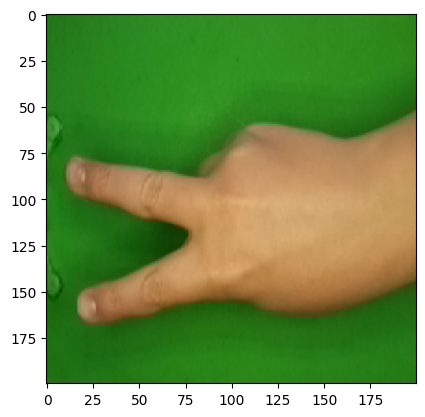

In [41]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(200,200))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  x = tf.keras.applications.efficientnet.preprocess_input(x)

  classes = saved_model.predict(x)

  class_index = np.argmax(classes)
  print(class_index)
  print(class_labels)
  print(classes)

  predicted_label = class_labels[class_index]
  print(f"Predicted label: {predicted_label}")